In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from holidays import Indonesia
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # Sudah ada, tapi konfirmasi
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib

In [2]:
df = pd.read_csv("data IN 2024.csv", on_bad_lines="warn")

# Load dan Eksplorasi Data (Initial Inspection)

In [3]:
df.shape

(53745, 11)

In [4]:
print(df.info())  # Tipe data dan non-null count
print(df.shape)   # (baris, kolom)
print(df.isnull().sum())  # Missing per kolom
print(df.describe())  # Statistik numerical
print(df['Category'].unique())  # Unique untuk kategorikal

#identifiying garbages value
for i in df.select_dtypes(include="object").columns:
  print(df[i].value_counts())
  print("***"*10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53745 entries, 0 to 53744
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Number                   53745 non-null  int64 
 1   Status                   53745 non-null  object
 2   Priority                 53745 non-null  object
 3   Category                 53745 non-null  object
 4   Open Date                53745 non-null  object
 5   Closed Date              49836 non-null  object
 6   Due Date                 53745 non-null  object
 7   Time Left Incl. On Hold  53745 non-null  int64 
 8   Item                     53745 non-null  object
 9   Sub Category             3487 non-null   object
 10  Closure Category         52371 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.5+ MB
None
(53745, 11)
Number                         0
Status                         0
Priority                       0
Category                       0
Ope

# Handle Missing Values

In [5]:
#drop baris nan pada closed date
df = df.dropna(subset=['Closed Date'])

#Sub Category: Isi dengan 'Unknown'
df["Sub Category"] = df["Sub Category"].fillna("Unknown")

#Closure Category: Isi dengan mode ('Solved') untuk nan
df['Closure Category'] = df['Closure Category'].fillna(df['Closure Category'].mode()[0])

# Lowercase dan strip Category (sudah ada)
df["Category"] = df["Category"].str.lower().str.strip()

# Cek missing setelah handling (tambahan untuk verifikasi)
print("Missing values setelah handling:")
print(df.isnull().sum())

Missing values setelah handling:
Number                     0
Status                     0
Priority                   0
Category                   0
Open Date                  0
Closed Date                0
Due Date                   0
Time Left Incl. On Hold    0
Item                       0
Sub Category               0
Closure Category           0
dtype: int64


#Konversi Tipe Data dan Cleaning

In [6]:
df['Category'] = df['Category'].astype(str).str.strip().str.title()
df['Item'] = df['Item'].astype(str).str.strip().str.title()

In [7]:
# --- 1 PRE-PROCESSING AWAL (Standardisasi Format) ---
# Ubah ke string, hapus spasi depan/belakang, ubah ke Title Case agar seragam
df['Item'] = df['Item'].astype(str).str.strip().str.title()

# --- 2. KAMUS MAPPING LENGKAP (ALL-IN-ONE) ---
# Menggabungkan semua perbaikan typo, akronim, dan duplikasi
item_mapping_complete = {
    # === BAGIAN 1: PERBAIKAN TYPO & FORMAT ===
    "Mozila Firefox": "Mozilla Firefox",
    "Rtgs (Real Time Gross Settlement)\\": "RTGS",
    "Dms (Document Management System": "DMS (Document)",
    "Cbas  (Credit Bureau Automation System)": "CBAS", # Spasi ganda
    "Cbas": "CBAS",
    "Cbas(Credit Bureau Automation System)": "CBAS",
    "Money Gram": "Moneygram",
    "Cripas (Rwa)": "CRIPAS",
    "Cripas": "CRIPAS",
    
    # === BAGIAN 2: PEMISAHAN SISTEM SPESIFIK ===
    "Dms (Document Management System)": "DMS (Document)",
    "Dms (Dash Board Monitoring System)": "DMS (Dashboard)",
    "Dms (Dashboard)": "DMS (Dashboard)", # Pastikan konsisten
    "Dms (Document)": "DMS (Document)",   # Pastikan konsisten

    # === BAGIAN 3: STANDARDISASI AKRONIM (UPPERCASE) ===
    # Masukkan semua variasi Title Case (dari langkah 2) ke Uppercase
    "Esb (Enterprise Service Bus)": "ESB",
    "Esb": "ESB",
    
    "Dhn (Daftar Hitam Nasional)": "DHN",
    "Daftar Hitam Nasional (Dhn)": "DHN",
    "Dhn": "DHN",
    
    "Rtgs (Real Time Gross Settlement)": "RTGS",
    "Rtgs": "RTGS",
    
    "Svs (Signature Verification System)": "SVS",
    "Svs": "SVS",
    
    "Rds (Report Distribution System)": "RDS",
    "Rds": "RDS",
    
    "Cms (Collateral Management System)": "CMS",
    "Cms - Leopard": "CMS",
    "Cms": "CMS",
    
    "Mpn (Pajak)": "MPN",
    "Mpn/ Pajak (Modul Penerimaan Negara)": "MPN",
    "Mpn": "MPN",
    
    "Etp (E Touch Point)": "ETP",
    "Etp (E Touch Point) ": "ETP",
    "Etp / Ucp": "ETP",
    "Bi - Etp": "ETP",
    "Etp": "ETP",
    
    "Ucp (User Choice Presentation)": "UCP",
    "Ucp": "UCP",
    
    "Crm (Customer Relationship Management)": "CRM",
    "Cimb One - Crm (Customer Relationship Management)": "CRM",
    "Crm/Pega": "CRM",
    "Crm": "CRM",
    
    "Sibs - As400": "SIBS",
    "Sibs": "SIBS",
    
    "Pc (Personal Computer)": "PC",
    "Pc": "PC",
    
    "Kyc (Know Your Customer)": "KYC",
    "Kyc": "KYC",
    
    "Gfms (Group Financial Management System)": "GFMS",
    "Gfms": "GFMS",
    
    "Active Directory(Ad)": "Active Directory",
    "Onecc (One Credit Card)": "OneCC",
    "Onecc": "OneCC",
    "Efs (Enterprise File Server)": "EFS",
    "Efs": "EFS",
    
    "Crs (Custody Retail System)": "CRS",
    "Crs": "CRS",
    
    # === BAGIAN 4: AKRONIM UMUM LAINNYA (Manual Capitalization) ===
    "Vpn": "VPN", "Sms": "SMS", "Bi": "BI", "Usb": "USB",
    "Ftp": "FTP", "Atm": "ATM", "Bifast": "BIFAST", "Ssb": "SSB",
    "Qed": "QED", "Mfp": "MFP", "Gl": "GL", "Cctv": "CCTV",
    "Wms": "WMS", "Cif": "CIF", "Api": "API", "Slik": "SLIK",
    "Aft": "AFT", "Idm": "IDM", "Ivas": "IVAS", "Aml": "AML",
    "Opx": "OPX", "Ups": "UPS", "Alm": "ALM", "Aicms": "AICMS",
    "Nac": "NAC", "Lcr": "LCR", "Sics": "SICS", "Ojk": "OJK",
    "Siska": "SISKA", "Sdb": "SDB", "Swift": "SWIFT", "Esq": "ESQ",
    "Fds": "FDS", "Clms": "CLMS", "Smi": "SMI", "Mfts": "MFTS",
    "Orm": "ORM", "Bcs": "BCS", "Aovi": "AOVI", "Bds": "BDS",
    "Cirs": "CIRS", "Ifrs": "IFRS", "Ams": "AMS", "Itm": "ITM",
    "Edc": "EDC"
}

# --- 3. TERAPKAN MAPPING ---
df['Item'] = df['Item'].replace(item_mapping_complete)

# --- 4. VALIDASI HASIL ---
print("--- TOTAL UNIQUE ITEMS SETELAH MAPPING LENGKAP ---")
print(df['Item'].nunique())
print("\n--- 30 ITEM PERTAMA ---")
print(df['Item'].unique())

# Opsional: Cek apakah masih ada duplikat huruf besar/kecil yang terlewat
# Caranya dengan membandingkan lower case
# Cek Validasi yang Benar (Mencari 1 item yang punya >1 cara penulisan)
cek_variasi = df.groupby(df['Item'].str.lower())['Item'].nunique()
variasi_ganda = cek_variasi[cek_variasi > 1]

if variasi_ganda.empty:
    print("✅ SEMPURNA! Tidak ada duplikasi penulisan (case sensitivity).")
else:
    print("⚠️ Masih ada variasi untuk item berikut:")
    print(variasi_ganda)

--- TOTAL UNIQUE ITEMS SETELAH MAPPING LENGKAP ---
363

--- 30 ITEM PERTAMA ---
['BIFAST' 'SIBS' 'Server' 'GFMS' 'E-Statement' 'ITM' 'Custody Systems'
 'EDC' 'ESB' 'Octo Mobile' 'Laptop' 'Asccend' 'Network' 'SSB'
 'Mozilla Firefox' 'Bds Mv' 'ETP' 'Printer' 'Green Screen' 'CRM' 'VPN'
 'PC' 'OneCC' 'Active Directory' 'Cinnamon - Custody' 'CRIPAS'
 'Debit Card' 'Murex' 'UCP' 'Email' 'Medallion - Custody' 'EFS' 'DHN'
 'QED' 'Internet' 'Virtual Account' 'Port' 'Biz Channel' 'MFP' 'E-Kliring'
 'Sa (Saving Account)' 'Sms Broadcast' 'Yoda' 'GL'
 'Ms Team (Microsoft Team )' '- Information Technology' 'Sharing Folder'
 'Ret-Ad' 'Bds - Mosaic' 'E-Proofing' 'ATM' 'Trixie' 'Passbook'
 'Phone System' 'Tableau' 'Octo Clicks' 'CCTV' 'Branch Portal'
 'Dukcapil (Dokumen Catatan Sipil)' 'Scanner' 'DMS (Dashboard)' 'CBAS'
 'Spt (Sales Performance Tracking)' 'Office365' 'WMS' 'SVS' 'Wifi' 'Loan'
 'Rec-7 (Proactive Enterprise Reconciliations)' 'CIF'
 '3D (Digital Data Documentation)' 'Parameter Change' 'Tel

In [8]:
# Pastikan format dasar sudah Title Case
df['Category'] = df['Category'].astype(str).str.strip().str.title()

# Peta Normalisasi Kategori
category_map = {
    # 1. EOD (End Of Day) -> Fokus ke Production
    'Eod': 'EOD Production',
    'Eod (End Of Day)': 'EOD Production',
    'Eod Production': 'EOD Production',

    # 2. Problem/Issue
    'Problem': 'Application Problem',     # Asumsi mayoritas problem adalah aplikasi
    'Incident': 'Application Problem',
    'Host Problem': 'Infrastructure/Host Problem', # Bedakan karena ini level server

    # 3. Email -> Gabung aktivitas kirim/terima, pisahkan arsip jika perlu
    'Kirim Email': 'Email Service',
    'Terima Email': 'Email Service',
    'Kirim & Terima Email': 'Email Service',
    'Email': 'Email Service',
    'Archive Email': 'Email Archive', # Biasanya SLA-nya lebih longgar/beda

    # 4. Login Issues -> Fokus ke kegagalan akses
    'Tidak Dapat Login': 'Login Failed',
    'Cannot Access': 'Login Failed',
    
    # 5. Password/PIN -> Gabung semua reset kredensial
    'Password': 'Reset Password/PIN',
    'Reset Password': 'Reset Password/PIN',
    'Pin': 'Reset Password/PIN',
    'Passcode': 'Reset Password/PIN',

    # 6. User Management -> Administrasi user
    'User': 'User Management',
    'User Id': 'User Management',
    'Hapus User Id': 'User Management',

    # 7. Installation -> Gabung install/re-install
    'Install': 'Software Installation',
    'Install Aplikasi': 'Software Installation',
    'Re-Install': 'Software Installation',

    # 8. Application/Software -> Standarisasi
    'Application': 'Application Support',
    'Software': 'Application Support',
    'Application/Software': 'Application Support',

    # 9. Computer/Device -> Hardware PC/Laptop
    'Pc': 'PC/Laptop Issue',
    'Setting Pc': 'PC/Laptop Issue',
    'Laptop': 'PC/Laptop Issue',

    # 10. Payment/Angsuran -> Transaksi Kredit
    'Payment': 'Payment/Angsuran',
    'Angsuran': 'Payment/Angsuran',
    'Angsuran Pinjaman': 'Payment/Angsuran',
    'Payment/Angsuran/Setoran': 'Payment/Angsuran',
    'Tax Payment': 'Tax Payment', # Biarkan beda jika pajak punya deadline ketat

    # 11. Transfer -> Transaksi Dana
    'Transfer Ke Bank Lain': 'Fund Transfer',
    'Transfer Internal Bank': 'Fund Transfer',

    # 12. Branch Operations -> Operasional Cabang
    'Cannot Open Branch': 'Branch Operation Issue',
    'Cannot Close Branch': 'Branch Operation Issue',

    # 13. Download -> Pengambilan Data
    'Download Data': 'Data Download/Request',
    'Download File': 'Data Download/Request',
    
    # 14. Request/Permintaan -> Permintaan Layanan
    'Permintaan/Request': 'Service Request',
    'Permintaan Data': 'Data Download/Request', # Gabung ke download
    'Change Request': 'Change Request', # Biasanya SLA lebih lama

    # 15. USB Port -> Keamanan Endpoint
    'Block Usb Port': 'USB Access Control',
    'Open Usb Port': 'USB Access Control',

    # 16. Server/Host/Network -> Infrastruktur
    'Host': 'Infrastructure (Server/Network)',
    'Server': 'Infrastructure (Server/Network)',
    'Network': 'Infrastructure (Server/Network)',
    
    # 17. Hardware -> Perangkat Keras Fisik
    'Change Hardware': 'Hardware Replacement',
    'Printer': 'Hardware (Printer)', # Printer sering rusak, SLA mungkin beda
}

# Terapkan Mapping
df['Category'] = df['Category'].replace(category_map)

# Cek hasil
print(df['Category'].unique())

['Kegagalan Proses' 'Event Monitoring' 'EOD Production' 'Transaction'
 'Tidak Bisa Dilakukan' 'Drop' 'Login Failed'
 'Penjelasan Detail Sebuah Transaksi' 'Application Problem' 'Issue Card'
 'Mailbox Full' 'Aft' 'Notification' 'Koneksi Lambat' 'Maintenance'
 'Reset Password/PIN' 'Upload' 'Email Archive' 'Tidak Bisa Tutup Rekening'
 'Setting Connection' 'Sharing Folder' 'Bunga' 'Hold Amount' 'Intermitten'
 'Information' 'Service Request' 'Reporting' 'Blokir' 'Cetak Passbook'
 'Biaya-Biaya Pd Rekening' 'Infrastructure/Host Problem' 'Repair'
 'Branch Operation Issue' 'Gagal Debet' 'Time Out' 'Delete'
 'User Management' 'Mengaktifkan' 'Ip Address' 'Rekening Terdebet'
 'Others' 'Hardware (Printer)' 'Uim' 'Backup' 'Correction'
 'Software Installation' 'Email Service' 'Rerun' 'Migration'
 'Connectivity' 'Data Download/Request' 'Update' 'Payment/Angsuran'
 'Cara Penggunaan Feature/Aplikasi' 'Data' 'Upgrade' 'Change' 'News'
 'Remove' 'History Transaksi' 'Tax Payment'
 'Infrastructure (Server/Net

In [9]:
#konversi waktu
df['Open Date'] = pd.to_datetime(df['Open Date'], format='%m/%d/%Y %H:%M')
df['Closed Date'] = pd.to_datetime(df['Closed Date'], format='%m/%d/%Y %H:%M')
df['Due Date'] = pd.to_datetime(df['Due Date'], format='%m/%d/%Y %H:%M')


# Cleaning text
for col in ['Category', 'Sub Category', 'Item']:
    df[col] = df[col].str.lower().str.strip()  # Lowercase dan trim

# Handle Outliers dan Duplikat

In [10]:
# # Buat fitur Is SLA Violated
# # Logika: 1 jika Closed Date > Due Date DAN Time Left Incl. On Hold < 0, 0 jika tidak
df['Is SLA Violated'] = (((df['Closed Date'] > df['Due Date']) | (df['Time Left Incl. On Hold'] < 0))).astype(int)

# Feature Engineering


In [11]:
# Handle missing values (opsional, hapus baris dengan tanggal atau Time Left hilang)
df = df.dropna(subset=['Open Date', 'Closed Date', 'Due Date', 'Category', 'Item'])

# Tampilkan hasil
print(df[['Number', 'Open Date', 'Closed Date', 'Due Date', 'Time Left Incl. On Hold', 'Is SLA Violated']].head(50))

     Number           Open Date         Closed Date            Due Date  \
0   3226220 2024-01-01 01:39:00 2024-01-03 19:03:00 2024-01-05 17:30:00   
1   3226221 2024-01-01 01:50:00 2024-01-03 19:02:00 2024-01-02 17:30:00   
2   3226222 2024-01-01 02:00:00 2024-01-05 19:03:00 2024-01-02 17:30:00   
3   3226223 2024-01-01 02:37:00 2024-01-04 19:00:00 2024-01-05 17:30:00   
4   3226224 2024-01-01 03:17:00 2024-01-26 19:00:00 2024-01-05 17:30:00   
5   3226225 2024-01-01 04:24:00 2024-01-03 19:02:00 2024-01-05 17:30:00   
6   3226227 2024-01-01 07:25:00 2024-01-08 19:01:00 2024-01-05 17:30:00   
7   3226228 2024-01-01 08:20:00 2024-01-04 19:00:00 2024-01-02 17:30:00   
8   3226229 2024-01-01 08:46:00 2024-01-04 19:00:00 2024-01-08 08:46:00   
9   3226239 2024-01-01 11:57:00 2024-01-04 19:00:00 2024-01-08 11:57:00   
10  3226247 2024-01-01 15:56:00 2024-01-04 19:00:00 2024-01-08 15:56:00   
11  3226250 2024-01-01 17:12:00 2024-01-04 19:00:00 2024-01-08 17:12:00   
12  3226251 2024-01-01 17

In [12]:
#is holiday
df['Open Date'] = pd.to_datetime(df['Open Date'], errors='coerce')
df['Due Date'] = pd.to_datetime(df['Due Date'], errors='coerce')

years = [2024, 2025]  # Tambah tahun lain jika perlu
holidays_id = Indonesia(years=years)

# Konversi holidays_id ke set datetime untuk kompatibilitas dengan isin
holiday_dates = pd.to_datetime(list(holidays_id.keys()))  # Ambil semua tanggal dari holidays_id

# Buat fitur Is Open Date Off (vektorized dengan perbaikan)
df['Is Open Date Off'] = (((df['Open Date'].isin(holiday_dates)) | (df['Open Date'].dt.weekday >= 5))).astype(int)

# Buat fitur Is Due Date Off (vektorized dengan perbaikan)
df['Is Due Date Off'] = (((df['Due Date'].isin(holiday_dates)) | (df['Due Date'].dt.weekday >= 5))).astype(int)

# Handle missing values (opsional, hapus baris dengan tanggal hilang)
df = df.dropna(subset=['Open Date', 'Due Date'])

# Tampilkan hasil
print(df[['Number', 'Open Date', 'Due Date', 'Is Open Date Off', 'Is Due Date Off']].head())

    Number           Open Date            Due Date  Is Open Date Off  \
0  3226220 2024-01-01 01:39:00 2024-01-05 17:30:00                 0   
1  3226221 2024-01-01 01:50:00 2024-01-02 17:30:00                 0   
2  3226222 2024-01-01 02:00:00 2024-01-02 17:30:00                 0   
3  3226223 2024-01-01 02:37:00 2024-01-05 17:30:00                 0   
4  3226224 2024-01-01 03:17:00 2024-01-05 17:30:00                 0   

   Is Due Date Off  
0                0  
1                0  
2                0  
3                0  
4                0  


In [13]:
# Tambah fitur baru: Days to Due
df['Days to Due'] = (df['Due Date'] - df['Open Date']).dt.days

# Tambah temporal: Month dari Open Date (untuk tren)
df['Open Month'] = df['Open Date'].dt.month

In [14]:
#hari tiket dibuka dalam seminggu
df['Application Creation Day of Week'] = df['Open Date'].dt.dayofweek + 1  # +1 agar Senin = 1
print(df[['Number', 'Open Date', 'Application Creation Day of Week']].head())

    Number           Open Date  Application Creation Day of Week
0  3226220 2024-01-01 01:39:00                                 1
1  3226221 2024-01-01 01:50:00                                 1
2  3226222 2024-01-01 02:00:00                                 1
3  3226223 2024-01-01 02:37:00                                 1
4  3226224 2024-01-01 03:17:00                                 1


In [15]:
#jam tiket dibuka
df['Application Creation Hour'] = df['Open Date'].dt.hour
print(df[['Number', 'Open Date', 'Application Creation Hour']].head())

    Number           Open Date  Application Creation Hour
0  3226220 2024-01-01 01:39:00                          1
1  3226221 2024-01-01 01:50:00                          1
2  3226222 2024-01-01 02:00:00                          2
3  3226223 2024-01-01 02:37:00                          2
4  3226224 2024-01-01 03:17:00                          3


In [16]:
#hari deadline tiket dalam seminggu
df['Application SLA Deadline Day of Week'] = df['Due Date'].dt.dayofweek + 1  # +1 agar Senin = 1
print(df[['Number', 'Due Date', 'Application SLA Deadline Day of Week']].head())

    Number            Due Date  Application SLA Deadline Day of Week
0  3226220 2024-01-05 17:30:00                                     5
1  3226221 2024-01-02 17:30:00                                     2
2  3226222 2024-01-02 17:30:00                                     2
3  3226223 2024-01-05 17:30:00                                     5
4  3226224 2024-01-05 17:30:00                                     5


In [17]:
#Jam deadline tiket
df['Application SLA Deadline Hour'] = df['Due Date'].dt.hour
print(df[['Number', 'Due Date', 'Application SLA Deadline Hour']].head())

    Number            Due Date  Application SLA Deadline Hour
0  3226220 2024-01-05 17:30:00                             17
1  3226221 2024-01-02 17:30:00                             17
2  3226222 2024-01-02 17:30:00                             17
3  3226223 2024-01-05 17:30:00                             17
4  3226224 2024-01-05 17:30:00                             17


In [18]:
df.head()

,Number,Status,Priority,Category,Open Date,Closed Date,Due Date,Time Left Incl. On Hold,Item,Sub Category,Closure Category,Is SLA Violated,Is Open Date Off,Is Due Date Off,Days to Due,Open Month,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour
0,3226220,Closed,Low,kegagalan proses,2024-01-01 01:39:00,2024-01-03 19:03:00,2024-01-05 17:30:00,2700,bifast,unknown,Solved,0,0,0,4,1,1,1,5,17
1,3226221,Closed,Medium,kegagalan proses,2024-01-01 01:50:00,2024-01-03 19:02:00,2024-01-02 17:30:00,1080,sibs,unknown,Solved,1,0,0,1,1,1,1,2,17
2,3226222,Closed,Medium,kegagalan proses,2024-01-01 02:00:00,2024-01-05 19:03:00,2024-01-02 17:30:00,477,sibs,unknown,Solved,1,0,0,1,1,1,2,2,17
3,3226223,Closed,Low,event monitoring,2024-01-01 02:37:00,2024-01-04 19:00:00,2024-01-05 17:30:00,2700,server,sub kategori 49,Solved,0,0,0,4,1,1,2,5,17
4,3226224,Closed,Low,kegagalan proses,2024-01-01 03:17:00,2024-01-26 19:00:00,2024-01-05 17:30:00,-6089,gfms,unknown,Solved,1,0,0,4,1,1,3,5,17


# Feature Engineering dengan rumus

In [19]:
#Persiapan
# Handle missing values
df = df.dropna(subset=['Open Date', 'Closed Date', 'Due Date', 'Category', 'Item'])

# Tambah durasi resolusi sementara (dalam hari)
df['Resolution Duration'] = (df['Closed Date'] - df['Open Date']).dt.total_seconds() / 86400  #

In [20]:
print("Distribusi SLA:")
print(df['Is SLA Violated'].value_counts())

print("\nProporsi SLA:")
print(df['Is SLA Violated'].value_counts(normalize=True))

Distribusi SLA:
Is SLA Violated
0    38729
1    11107
Name: count, dtype: int64

Proporsi SLA:
Is SLA Violated
0    0.777129
1    0.222871
Name: proportion, dtype: float64


In [21]:
# Average Resolution Time per Category
#Fungsi: Menghitung rata-rata waktu penyelesaian tiket berdasarkan kategori.
#Tujuan: Mengetahui kategori mana yang rata-rata lebih lama/cepat dalam menyelesaikan tiket.
#Kegunaan: Bisa jadi indikator bottleneck (misalnya, kategori "Network Issue" rata-rata butuh 5 hari, sedangkan "Password Reset" cuma 1 hari).
avg_resolution_time = df.groupby('Category')['Resolution Duration'].mean().reset_index()
avg_resolution_time.columns = ['Category', 'Average Resolution Time (Ac)']

# SLA to Average Resolution Ratio
#Fungsi: Membandingkan rata-rata waktu penyelesaian dengan SLA yang diberikan.
#Tujuan: Mengetahui apakah penyelesaian tiket biasanya masih dalam batas SLA atau sudah melampaui.
#Kegunaan: Kalau rasio mendekati/lebih dari 1 → artinya resolusi sering melampaui SLA.
sla_duration = df.groupby('Category')['Time Left Incl. On Hold'].median().reset_index()
sla_duration.columns = ['Category', 'SLA Duration']
temp_df = avg_resolution_time.merge(sla_duration, on='Category', how='left')
temp_df['SLA to Average Resolution Ratio (Rc)'] = temp_df.apply(
    lambda row: row['Average Resolution Time (Ac)'] / row['SLA Duration'] if row['SLA Duration'] > 0 else 0, axis=1
)

# Total Tickets Resolved in Last n Days
#Fungsi: Menghitung jumlah tiket yang diselesaikan dalam periode tertentu (misalnya 7 hari terakhir).
#Tujuan: Melihat produktivitas penyelesaian tiket per kategori dalam jangka pendek.
#Kegunaan: Jadi indikator beban kerja dan tren (misalnya apakah ada lonjakan tiket mendekati akhir tahun).
df_sorted = df.sort_values('Closed Date')  # Sort untuk rolling
df['Total Tickets Resolved (Wc)'] = df.groupby('Category')['Closed Date'].transform(
    lambda x: x.rolling(window=7, min_periods=1).count()  # Count resolved in last 7 days per category
)

# Application SLA Compliance Rate
#Fungsi: Menghitung persentase kepatuhan SLA berdasarkan aplikasi/item.
#Tujuan: Mengetahui seberapa sering tiket untuk aplikasi tertentu berhasil diselesaikan tepat waktu.
#Kegunaan: Jika compliance rate rendah, berarti aplikasi tersebut sering mengalami keterlambatan penyelesaian insiden.
#sla_threshold = {'1 - Critical': 2/24, '2 - High': 6/24, '3 - Medium': 3, '4 - Low': 5}  # Dalam days
sla_threshold = {
    '1 - Critical': 2/24 + 3,  # 3 hari + 2 jam
    '2 - High': 6/24 + 3,      # 3 hari + 6 jam
    '3 - Medium': 3 + 3,       # total 6 hari
    '4 - Low': 5 + 3           # total 8 hari
}

df['SLA Threshold'] = df['Priority'].map(sla_threshold)
#df['Is SLA Violated'] = ((df['Resolution Duration'] > df['SLA Threshold']) | (df['Time Left Incl. On Hold'] < 0)).astype(int)
df['Is SLA Violated'] = (((df['Closed Date'] > df['Due Date']) | (df['Time Left Incl. On Hold'] < 0))).astype(int)

compliance_rate = df.groupby('Item').apply(
    lambda x: (1 - x['Is SLA Violated'].mean()) if len(x) > 0 else 0
).reset_index(name='Application SLA Compliance Rate')

# Gabungkan semua
df = df.merge(avg_resolution_time, on='Category', how='left')
df = df.merge(temp_df[['Category', 'SLA to Average Resolution Ratio (Rc)']], on='Category', how='left')
df = df.merge(compliance_rate, on='Item', how='left').fillna(0)  # Fill Wc 0 jika NaN

# Tampilkan sample
print(df[['Category', 'Average Resolution Time (Ac)', 'SLA to Average Resolution Ratio (Rc)',
          'Total Tickets Resolved (Wc)', 'Item', 'Application SLA Compliance Rate', 'Is SLA Violated']].head())

           Category  Average Resolution Time (Ac)  \
0  kegagalan proses                      5.875479   
1  kegagalan proses                      5.875479   
2  kegagalan proses                      5.875479   
3  event monitoring                      4.372967   
4  kegagalan proses                      5.875479   

   SLA to Average Resolution Ratio (Rc)  Total Tickets Resolved (Wc)    Item  \
0                               0.00234                          1.0  bifast   
1                               0.00234                          2.0    sibs   
2                               0.00234                          3.0    sibs   
3                               0.00162                          1.0  server   
4                               0.00234                          4.0    gfms   

   Application SLA Compliance Rate  Is SLA Violated  
0                         0.860599                0  
1                         0.378309                1  
2                         0.378309    

C:\Users\stefa\AppData\Local\Temp\ipykernel_31904\2593350364.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  compliance_rate = df.groupby('Item').apply(


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Setup CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Target
y = df['Is SLA Violated']

# pengecualian fitur agar tdk overfit:
exclude_cols = ['Is SLA Violated', 'Number', 'Open Date', 'Closed Date', 'Due Date',
                'Resolution Duration', 'Time Left Incl. On Hold', 'SLA Threshold', 'Status',
                'Closure Category', 'Average Resolution Time (Ac)',
                'SLA to Average Resolution Ratio (Rc)',
                'Total Tickets Resolved (Wc)',
                'Application SLA Compliance Rate']

feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols]

In [23]:
# pd.set_option('display.max_columns', None)
# df.head()

# Encoding Kategorikal dan Scaling Numerical

In [24]:
# Label encode kategorikal (fit pada train nanti, tapi untuk sekarang, encode seluruh df dulu sebagai prep – tapi transform train/test terpisah)
categorical_cols = ['Priority', 'Category', 'Item', 'Sub Category']  # Status sudah di-drop

# Drop Status jika ada
df = df.drop(columns=['Status', 'Closure Category', ''], errors='ignore')


In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modifikasi fungsi: Return le juga (agar bisa save)
def safe_label_encode(train_df, test_df, col):
    le = LabelEncoder()
    # Fit & transform train
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    # Transform test: unseen -> -1
    classes = set(le.classes_)
    test_encoded = test_df[col].astype(str).apply(lambda x: le.transform([x])[0] if x in classes else -1)
    test_df[col] = test_encoded
    return train_df, test_df, le  # Return le juga!

print("Fungsi safe_label_encode diupdate (sekarang return le)")

# Apply encoding
# Cell Fix: Loop Encoding dengan unpack 3 + simpan encoders
encoders = {}  # Dict untuk simpan le per kolom

for col in categorical_cols:
    X_train, X_test, le = safe_label_encode(X_train, X_test, col)  # Unpack 3 variabel!
    encoders[col] = le  # Simpan le
    print(f"Encoded {col}: Classes = {le.classes_[:5]}...")  # Debug sample classes

print(f"Encoding selesai! Encoders keys: {list(encoders.keys())}")

# FIX 2: Scaling hanya kolom numerical
numerical_cols = ['Days to Due']
if numerical_cols and not X_train.empty:
    scaler = MinMaxScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print(f"Scaling selesai untuk {numerical_cols}")

categorical_features_names = [
    'Priority',
    'Category',
    'Item',
    'Sub Category',
    'Is Open Date Off',
    'Is Due Date Off',
    'Open Month',
    'Application Creation Day of Week',
    'Application Creation Hour',
    'Application SLA Deadline Day of Week',
    'Application SLA Deadline Hour'
]

# 2. Dapatkan indeks-nya secara dinamis
# SMOTENC butuh indeks (angka), bukan nama kolom
try:
    all_feature_names = X_train.columns.tolist()
    categorical_indices = [all_feature_names.index(col) for col in categorical_features_names if col in all_feature_names]
    print(f"Indeks kolom kategorikal untuk SMOTENC: {categorical_indices}")
except ValueError as e:
    print(f"ERROR: Kolom '{e.args[0].split()[0]}' tidak ditemukan di X_train.columns.")
    # Hentikan proses jika ada error, karena SMOTENC akan gagal
    raise e

# 3. Cek k_neighbors (PENTING)
# Ini untuk mencegah error jika kelas minoritas terlalu kecil
n_minority_samples = y_train.value_counts().min()
k = min(5, n_minority_samples - 1) # k_neighbors default adalah 5

# 4. Inisialisasi dan jalankan SMOTENC
if k > 0:
    print(f"Menjalankan SMOTENC dengan k_neighbors={k}...")
    smote_nc = SMOTENC(
        categorical_features=categorical_indices,
        sampling_strategy=0.75,
        random_state=42,
        k_neighbors=k
    )

    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    print("SMOTENC Selesai.")
    print("Distribusi y_train setelah SMOTENC:", pd.Series(y_train_resampled).value_counts(normalize=True))
else:
    # 5. Fallback jika sampel terlalu sedikit
    print(f"WARNING: Sampel minoritas ({n_minority_samples}) terlalu sedikit untuk SMOTENC.")
    print("Menggunakan data training asli (tanpa resampling).")
    X_train_resampled, y_train_resampled = X_train, y_train

Fungsi safe_label_encode diupdate (sekarang return le)
Encoded Priority: Classes = ['2 - High' 'Critical' 'Low' 'Medium']...
Encoded Category: Classes = ['add' 'aft' 'application problem' 'application support' 'backup']...
Encoded Item: Classes = ['- information technology' '3d (digital data documentation)'
 'access server' 'acs cisco work' 'active directory']...
Encoded Sub Category: Classes = ['sub kategori 1' 'sub kategori 10' 'sub kategori 11' 'sub kategori 12'
 'sub kategori 14']...
Encoding selesai! Encoders keys: ['Priority', 'Category', 'Item', 'Sub Category']
Scaling selesai untuk ['Days to Due']
Indeks kolom kategorikal untuk SMOTENC: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
Menjalankan SMOTENC dengan k_neighbors=5...
SMOTENC Selesai.
Distribusi y_train setelah SMOTENC: Is SLA Violated
0    0.571431
1    0.428569
Name: proportion, dtype: float64


In [26]:
# 1. Gabungkan Fitur (X) dan Target (y) data testing
df_test_processed = X_test.copy()
df_test_processed['Is SLA Violated'] = y_test

# 2. Simpan ke CSV
df_test_processed.to_csv('data_test_processed.csv', index=False)

print("File 'data_test_processed.csv' berhasil disimpan!")
print(f"Jumlah baris: {len(df_test_processed)}")

File 'data_test_processed.csv' berhasil disimpan!
Jumlah baris: 9968


In [27]:
X_train

,Priority,Category,Item,Sub Category,Is Open Date Off,Is Due Date Off,Days to Due,Open Month,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour
20206,2,42,246,65,0,0,0.636364,5,2,10,2,10
3987,2,42,330,65,0,0,0.636364,1,1,15,1,15
8560,2,25,117,65,1,0,0.454545,3,6,20,5,17
19386,2,69,76,65,0,0,0.636364,5,3,14,3,14
3615,2,43,202,65,0,0,0.636364,1,5,11,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...
328,2,44,276,65,0,0,0.636364,1,3,9,3,9
41656,3,42,220,65,0,0,0.090909,9,2,23,4,17
36694,2,42,165,65,0,0,0.636364,8,1,12,1,12
41912,2,42,120,65,0,0,0.636364,9,4,12,4,12


In [28]:
X_test

,Priority,Category,Item,Sub Category,Is Open Date Off,Is Due Date Off,Days to Due,Open Month,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour
36939,2,42,235,65,0,0,0.636364,8,2,14,2,14
45926,2,44,338,65,0,0,0.636364,11,2,9,2,9
22250,2,44,338,65,0,0,0.636364,5,5,11,5,11
32429,2,44,36,65,0,0,0.636364,7,4,8,4,8
4202,2,42,36,65,0,0,0.545455,1,2,19,2,17
...,...,...,...,...,...,...,...,...,...,...,...,...
3359,2,42,280,65,0,0,0.636364,1,3,17,3,17
33707,2,38,276,65,0,0,0.636364,7,3,10,3,10
18120,2,44,338,65,0,0,0.636364,5,4,10,4,10
15147,2,44,338,65,0,0,0.636364,4,4,11,4,11


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier # Pastikan ini di-import
from scipy.stats import randint

# --- Gunakan hasil SMOTE ---
X_train_use = X_train_resampled
y_train_use = y_train_resampled

# ==========================================================================
# BAGIAN 1: TUNING PARAMETER (DICOMMENT AGAR TIDAK DIJALANKAN ULANG)
# ==========================================================================
# Bagian ini hanya perlu dijalankan SEKALI untuk mencari angka terbaik.

# 1. Tentukan model dasar
# rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# 2. Tentukan rentang parameter
# param_dist = {
#     'n_estimators': randint(100, 500),
#     'max_depth': [10, 20, 30, None],
#     'min_samples_leaf': randint(1, 5),
#     'min_samples_split': randint(2, 10),
#     'max_features': ['sqrt', 'log2', None]
# }

# 3. Setup RandomizedSearch
# rf_random_search = RandomizedSearchCV(
#     estimator=rf_base,
#     param_distributions=param_dist,
#     n_iter=50,
#     cv=cv,
#     scoring='f1_macro',
#     verbose=1,
#     random_state=42
# )

# 4. Jalankan pencarian 
# rf_random_search.fit(X_train_use, y_train_use)

# 5. Lihat hasilnya
# print(f"Parameter terbaik: {rf_random_search.best_params_}")
# print(f"Skor F1-Macro CV terbaik: {rf_random_search.best_score_:.4f}")

#OUTPUT
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# Parameter terbaik: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 195}
# Skor F1-Macro CV terbaik: 0.8374
# Parameter terbaik: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 195}
# Skor F1-Macro CV terbaik: 0.8374

# ==========================================================================
# BAGIAN 2: MODEL FINAL (DITAMBAHKAN / DIJALANKAN SETERUSNYA)
# ==========================================================================

rf_model = RandomForestClassifier(
    n_estimators=195,       
    max_depth=30,            
    min_samples_leaf=1,      
    min_samples_split=2,     
    max_features=None,     
    random_state=42,
    n_jobs=-1                
)

# ==========================================================================
# BAGIAN 3: CROSS VALIDATION & TRAINING (TETAP DIJALANKAN)
# ==========================================================================
# Ini tetap perlu dijalankan untuk memverifikasi performa model final Anda
cv_results = cross_validate(
    rf_model,
    X_train_use,
    y_train_use,
    cv=cv,
    scoring=['f1_macro', 'f1', 'accuracy', 'balanced_accuracy'], # Semua metrik dihitung di sini
    return_train_score=False
)

# Cross-validation di data hasil SMOTE
scores_f1_macro = cv_results['test_f1_macro']
scores_f1       = cv_results['test_f1']
scores_accuracy = cv_results['test_accuracy']

# 3. Print Hasil 
print(f'CV F1-Macro: {scores_f1_macro.mean():.4f} (+/- {scores_f1_macro.std() * 2:.4f})')
print(f'CV F1 (binary): {scores_f1.mean():.4f} (+/- {scores_f1.std() * 2:.4f})')
print(f'CV Accuracy: {scores_accuracy.mean():.4f} (+/- {scores_accuracy.std() * 2:.4f})')
print(f'Skor per fold (F1-macro): {scores_f1_macro}')
# Sekarang baris ini akan berhasil karena cv_results sudah didefinisikan
print(f'CV Balanced Accuracy: {cv_results["test_balanced_accuracy"].mean():.4f}')

# --- Train final model dengan data hasil SMOTE ---
rf_model.fit(X_train_use, y_train_use)


CV F1-Macro: 0.8370 (+/- 0.0068)
CV F1 (binary): 0.8141 (+/- 0.0087)
CV Accuracy: 0.8402 (+/- 0.0065)
Skor per fold (F1-macro): [0.8377217  0.83513824 0.84329985 0.83422166 0.83448332]
CV Balanced Accuracy: 0.8372


,n_estimators,195
,criterion,'gini'
,max_depth,30
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
from sklearn.metrics import f1_score
import numpy as np

print("Mencari threshold optimal untuk model SMOTENC baru...")

# 1. Dapatkan probabilitas untuk kelas '1' (Melanggar) pada X_test
# (Pastikan X_test dan y_test adalah data tes asli Anda)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

best_f1 = 0
best_threshold = 0.5 # Default

# 2. Loop melalui berbagai kemungkinan threshold
for threshold in np.arange(0.1, 0.9, 0.01):
    # Terapkan threshold
    y_pred_tuned = (y_pred_proba >= threshold).astype(int)

    # Hitung F1 score
    f1 = f1_score(y_test, y_pred_tuned) # Fokus pada kelas 1 (Melanggar)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("======================================================")
print(f"Threshold Optimal Baru: {best_threshold:.4f}")
print(f"F1 Score (Tuned): {best_f1:.4f}")
print("======================================================")

# 3. Simpan threshold ini
import joblib
joblib.dump(best_threshold, 'best_threshold.pkl')
print("File 'best_threshold.pkl' berhasil disimpan!")

Mencari threshold optimal untuk model SMOTENC baru...
Threshold Optimal Baru: 0.4500
F1 Score (Tuned): 0.5310
File 'best_threshold.pkl' berhasil disimpan!


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
import numpy as np

In [32]:
# 4️ Testing tetap pada data asli (tanpa SMOTE)
y_pred = rf_model.predict(X_test)

In [33]:
print("\n--- Menghasilkan Tabel 4.1: Hasil K-Fold CV ---")

# Ambil metrik yang relevan dari cv_results
cv_data = {
    'Fold': [f"Fold {i+1}" for i in range(len(cv_results['test_f1_macro']))],
    'F1-Score (Macro)': cv_results['test_f1_macro'],
    'Akurasi': cv_results['test_accuracy'],
    'Balanced Accuracy': cv_results['test_balanced_accuracy']
}

# Buat DataFrame
tabel_4_1 = pd.DataFrame(cv_data)

# Tambah baris rata-rata dan standar deviasi
mean_row = {
    'Fold': 'Rata-rata',
    'F1-Score (Macro)': tabel_4_1['F1-Score (Macro)'].mean(),
    'Akurasi': tabel_4_1['Akurasi'].mean(),
    'Balanced Accuracy': tabel_4_1['Balanced Accuracy'].mean()
}
std_row = {
    'Fold': 'Std. Dev.',
    'F1-Score (Macro)': tabel_4_1['F1-Score (Macro)'].std(),
    'Akurasi': tabel_4_1['Akurasi'].std(),
    'Balanced Accuracy': tabel_4_1['Balanced Accuracy'].std()
}

# Tambah baris ke DataFrame
tabel_4_1 = pd.concat([tabel_4_1, pd.DataFrame([mean_row]), pd.DataFrame([std_row])], ignore_index=True)

print(tabel_4_1.to_markdown(index=False))

# Simpan ke CSV untuk laporan
tabel_4_1.to_csv("hasil_tabel_4_1_kfold_cv.csv", index=False)


--- Menghasilkan Tabel 4.1: Hasil K-Fold CV ---
| Fold      |   F1-Score (Macro) |    Akurasi |   Balanced Accuracy |
|:----------|-------------------:|-----------:|--------------------:|
| Fold 1    |         0.837722   | 0.84111    |          0.837568   |
| Fold 2    |         0.835138   | 0.83862    |          0.834905   |
| Fold 3    |         0.8433     | 0.84609    |          0.844266   |
| Fold 4    |         0.834222   | 0.837145   |          0.835209   |
| Fold 5    |         0.834483   | 0.837975   |          0.834242   |
| Rata-rata |         0.836973   | 0.840188   |          0.837238   |
| Std. Dev. |         0.00379883 | 0.00361591 |          0.00412435 |


In [34]:
# --- Evaluasi di data uji asli ---
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)


accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_binary = f1_score(y_test, y_pred)

print(f'\nTest Accuracy: {accuracy:.4f}')
print(f'Test F1-Macro: {f1_macro:.4f}')
print(f'Test F1 (binary): {f1_binary:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print(f'\nROC-AUC Score: {roc_auc:.4f}')


Test Accuracy: 0.7847
Test F1-Macro: 0.6936
Test F1 (binary): 0.5265

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      7746
           1       0.52      0.54      0.53      2222

    accuracy                           0.78      9968
   macro avg       0.69      0.70      0.69      9968
weighted avg       0.79      0.78      0.79      9968


Confusion Matrix:
 [[6629 1117]
 [1029 1193]]

ROC-AUC Score: 0.7823


In [35]:
print(X_train.columns.tolist())

['Priority', 'Category', 'Item', 'Sub Category', 'Is Open Date Off', 'Is Due Date Off', 'Days to Due', 'Open Month', 'Application Creation Day of Week', 'Application Creation Hour', 'Application SLA Deadline Day of Week', 'Application SLA Deadline Hour']


# Feature Importance


Top 10 Feature Importances:
                                  feature  importance
2                                   Item    0.260078
7                             Open Month    0.157636
0                               Priority    0.132984
1                               Category    0.132239
9              Application Creation Hour    0.093479
11         Application SLA Deadline Hour    0.072982
8       Application Creation Day of Week    0.061963
10  Application SLA Deadline Day of Week    0.056444
6                            Days to Due    0.019522
3                           Sub Category    0.010716


C:\Users\stefa\AppData\Local\Temp\ipykernel_31904\3961161371.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', palette='viridis')


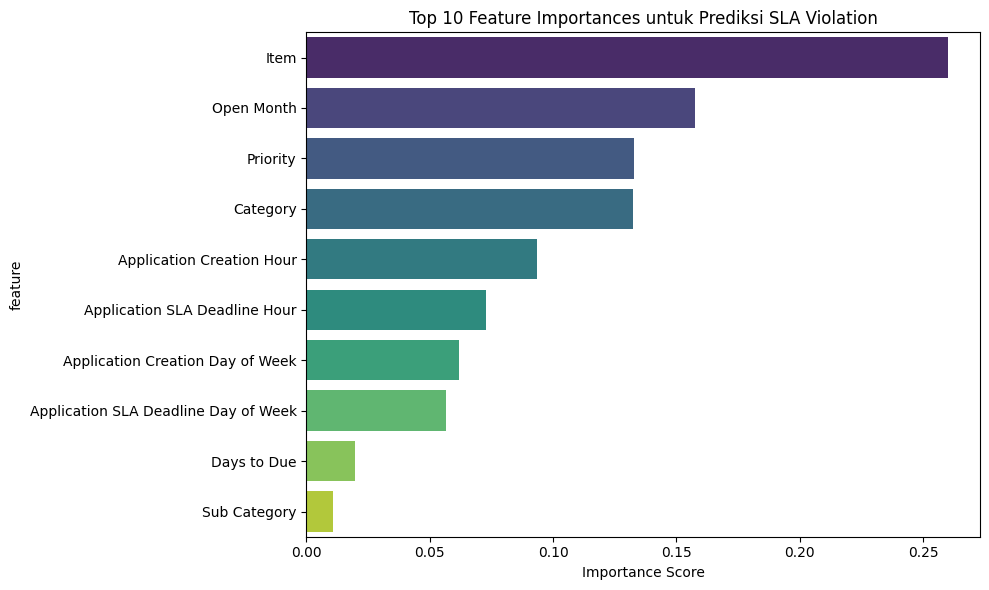

In [36]:
# TAMBAHAN: Feature Importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,  # Gunakan feature_cols dari sebelumnya
    'importance': importances
}).sort_values('importance', ascending=False)

print('\nTop 10 Feature Importances:\n', feature_importance_df.head(10))

# Plot visualisasi (opsional, tapi bagus untuk skripsi)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Feature Importances untuk Prediksi SLA Violation')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [37]:
feature_importance_list = feature_importance_df.to_dict('records')
import json
with open('feature_importances.json', 'w') as f:
    json.dump(feature_importance_list, f, indent=4)

print("Feature importances saved to feature_importances.json")

Feature importances saved to feature_importances.json


In [38]:
df.to_csv('dataset_random-forest.csv', index=False)
df.to_excel('dataset_random-forest.xlsx', index=False, sheet_name='Data Utama')

In [39]:
import joblib

# Asumsi: rf_model sudah fit, encoders & scaler dari atas
try:
    # Save model RF
    joblib.dump(rf_model, 'rf_sla_model.pkl')

    # Save encoders (dict untuk multiple kolom)
    joblib.dump(encoders, 'label_encoders.pkl')  # Semua le dalam dict

    # Save scaler
    joblib.dump(scaler, 'minmax_scaler.pkl')

    # Save feature names
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, 'feature_names.pkl')

    print("Model & artifacts saved! Files:")
    print("- rf_sla_model.pkl (Random Forest)")
    print("- label_encoders.pkl (Dict encoders per kolom)")
    print("- minmax_scaler.pkl (Scaler)")
    print("- feature_names.pkl (Kolom features)")

    # Test load & predict dummy
    loaded_model = joblib.load('rf_sla_model.pkl')
    dummy_X = np.zeros((1, len(feature_names)))
    pred = loaded_model.predict(dummy_X)[0]
    prob = loaded_model.predict_proba(dummy_X)[0][1]
    print(f"Test: Prediction = {pred}, Probability Violated = {prob:.2f}")

except NameError as e:
    print(f"Error: {e}. Pastikan rf_model, encoders, scaler, X_train ada.")
except Exception as e:
    print(f"Unexpected error: {e}")

Model & artifacts saved! Files:
- rf_sla_model.pkl (Random Forest)
- label_encoders.pkl (Dict encoders per kolom)
- minmax_scaler.pkl (Scaler)
- feature_names.pkl (Kolom features)
Test: Prediction = 0, Probability Violated = 0.36


c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Diagram dan Visualisasi


--- Menghasilkan Tabel 4.2 & 4.3: Evaluasi Awal (Threshold 0.5) ---

Tabel 4.3: Laporan Klasifikasi (Threshold 0.5)
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.865631 | 0.855797 |   0.860686 | 7746        |
| 1            |    0.51645  | 0.536904 |   0.526478 | 2222        |
| accuracy     |    0.784711 | 0.784711 |   0.784711 |    0.784711 |
| macro avg    |    0.69104  | 0.69635  |   0.693582 | 9968        |
| weighted avg |    0.787794 | 0.784711 |   0.786186 | 9968        |
Grafik 'hasil_gambar_tabel_4_2_cm_default.png' disimpan.


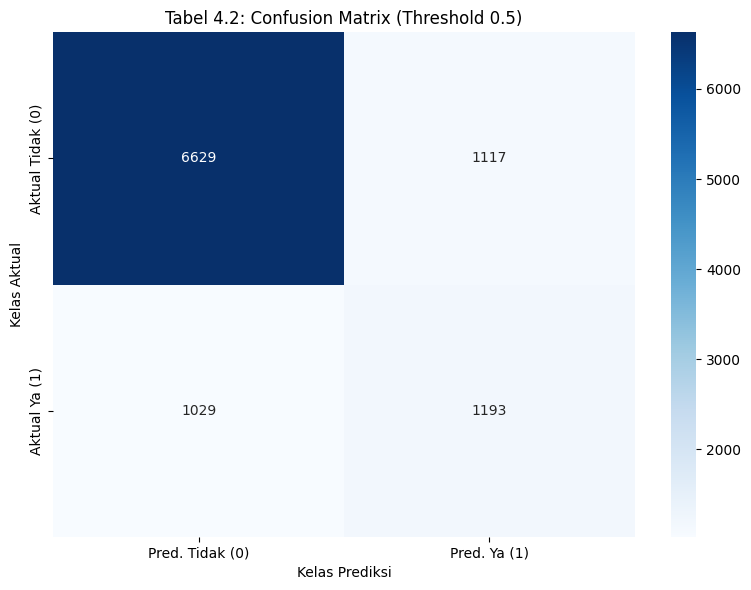

In [40]:
print("\n--- Menghasilkan Tabel 4.2 & 4.3: Evaluasi Awal (Threshold 0.5) ---")

# 1. Hitung Confusion Matrix (Default)
# (y_test dan y_pred seharusnya sudah ada dari script Anda)
cm_default = confusion_matrix(y_test, y_pred)
f1_default = f1_score(y_test, y_pred) # F1 untuk kelas 1 (Melanggar)

print("\nTabel 4.3: Laporan Klasifikasi (Threshold 0.5)")
report_default_dict = classification_report(y_test, y_pred, output_dict=True)
tabel_4_3 = pd.DataFrame(report_default_dict).transpose()
print(tabel_4_3.to_markdown())
tabel_4_3.to_csv("hasil_tabel_4_3_report_default.csv")

# 2. Plot Heatmap untuk Tabel 4.2
plt.figure(figsize=(8, 6))
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. Tidak (0)', 'Pred. Ya (1)'],
            yticklabels=['Aktual Tidak (0)', 'Aktual Ya (1)'])
plt.title('Tabel 4.2: Confusion Matrix (Threshold 0.5)')
plt.ylabel('Kelas Aktual')
plt.xlabel('Kelas Prediksi')
plt.tight_layout()
plt.savefig("hasil_gambar_tabel_4_2_cm_default.png")
print("Grafik 'hasil_gambar_tabel_4_2_cm_default.png' disimpan.")


--- Menghasilkan Gambar 4.2: Kurva ROC-AUC ---
Grafik 'hasil_gambar_4_2_roc_auc.png' disimpan.


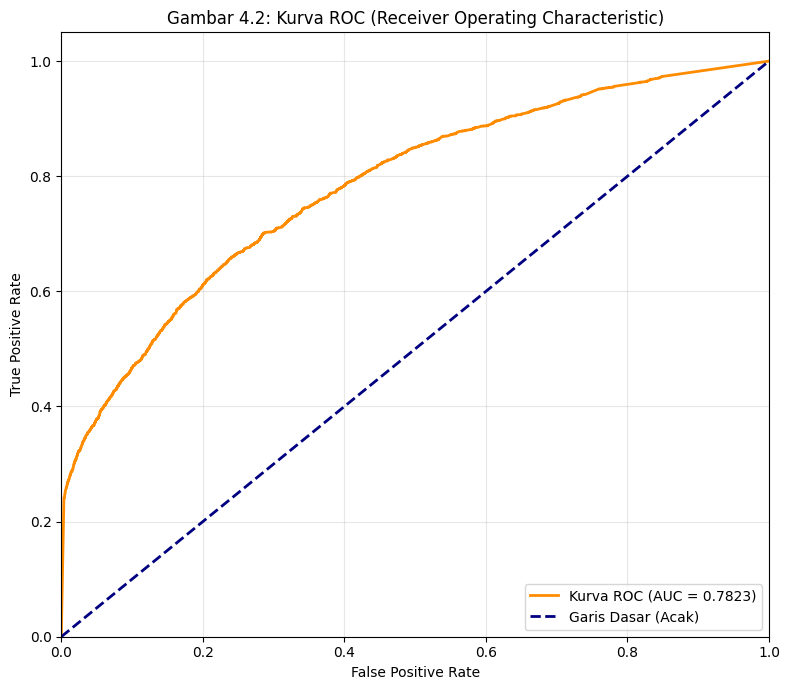

In [41]:
print("\n--- Menghasilkan Gambar 4.2: Kurva ROC-AUC ---")

# (roc_auc seharusnya sudah ada dari script Anda)
# roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Kurva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Garis Dasar (Acak)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gambar 4.2: Kurva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("hasil_gambar_4_2_roc_auc.png")
print("Grafik 'hasil_gambar_4_2_roc_auc.png' disimpan.")

# Melakukan klasifikasi dengan data baru

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import f1_score
import warnings

warnings.filterwarnings('ignore')

# ==============================================================================
# BAGIAN 1: TRAINING MODEL (TANPA SUB CATEGORY)
# ==============================================================================

print("--- [1/3] Memulai Training & Tuning... ---")

# 1. Load Data
try:
    df = pd.read_csv("data IN 2024.csv", on_bad_lines="warn")
except FileNotFoundError:
    print("Warning: File csv tidak ditemukan. Menggunakan dummy data untuk demo.")
    # Dummy data agar kode tetap bisa jalan (contoh struktur)
    df = pd.DataFrame({
        'Priority': ['Low', 'High', 'Medium', 'Critical'] * 25,
        'Category': ['Kegagalan Proses', 'Event Monitoring', 'Application Problem', 'Network'] * 25,
        'Item': ['SIBS', 'Server', 'Bifast', 'Firewall'] * 25,
        'Open Date': pd.date_range(start='2024-01-01', periods=100),
        'Due Date': pd.date_range(start='2024-01-03', periods=100),
        'Closed Date': pd.date_range(start='2024-01-02', periods=100),
        'Time Left Incl. On Hold': np.random.randint(-10, 100, 100)
    })

# 2. Preprocessing Function (Tanpa Sub Category)
def preprocess_dataframe(df_input, is_training=True):
    df_proc = df_input.copy()
    
    # Standardisasi teks (Hanya kolom yang dipakai: Priority, Category, Item)
    text_cols = ['Priority', 'Category', 'Item']
    for col in text_cols:
        if col in df_proc.columns:
            df_proc[col] = df_proc[col].astype(str).str.lower().str.strip()

    # Konversi tanggal
    for col in ['Open Date', 'Due Date']:
        df_proc[col] = pd.to_datetime(df_proc[col], errors='coerce')

    # Fitur Hari Libur (Sederhana: Hanya Sabtu/Minggu)
    # Logika: 1 jika Sabtu/Minggu, 0 jika Hari Kerja
    df_proc['Is Open Date Off'] = (df_proc['Open Date'].dt.weekday >= 5).astype(int)
    df_proc['Is Due Date Off'] = (df_proc['Due Date'].dt.weekday >= 5).astype(int)
    
    # Fitur Waktu
    df_proc['Days to Due'] = (df_proc['Due Date'] - df_proc['Open Date']).dt.days
    df_proc['Open Month'] = df_proc['Open Date'].dt.month
    df_proc['Application Creation Day of Week'] = df_proc['Open Date'].dt.dayofweek + 1
    df_proc['Application Creation Hour'] = df_proc['Open Date'].dt.hour
    df_proc['Application SLA Deadline Day of Week'] = df_proc['Due Date'].dt.dayofweek + 1
    df_proc['Application SLA Deadline Hour'] = df_proc['Due Date'].dt.hour
    
    # Target (Hanya saat training)
    if is_training:
        df_proc['Closed Date'] = pd.to_datetime(df_proc['Closed Date'], errors='coerce')
        df_proc = df_proc.dropna(subset=['Closed Date', 'Due Date', 'Open Date'])
        df_proc['Is SLA Violated'] = ((df_proc['Closed Date'] > df_proc['Due Date']) | 
                                      (df_proc['Time Left Incl. On Hold'] < 0)).astype(int)
    
    return df_proc

# Jalankan Preprocessing Train
df_train = preprocess_dataframe(df, is_training=True)

# Pilih Fitur (Sub Category dihapus dari daftar ini)
feature_cols = [
    'Priority', 'Category', 'Item', 
    'Is Open Date Off', 'Is Due Date Off', 'Days to Due', 'Open Month',
    'Application Creation Day of Week', 'Application Creation Hour', 
    'Application SLA Deadline Day of Week', 'Application SLA Deadline Hour'
]

# 1. Split dulu (80% train, 20% test) — stratify karena imbalance
X = df_train[feature_cols]
y = df_train['Is SLA Violated']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Data train: {X_train.shape} | Data test: {X_test.shape}")
print(f"Proporsi pelanggaran di test: {y_test.mean():.4f}")

# 2. Encoding & Scaling HARUS fit hanya pada TRAIN!
encoders = {}
for col in ['Priority', 'Category', 'Item']:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    encoders[col] = le                     # simpan untuk transform data baru nanti
    
    # Transform test dengan encoder yang sama (jika ada label baru → jadi -1 atau handle)
    X_test[col] = X_test[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Scaling juga fit hanya di train
scaler = MinMaxScaler()
X_train['Days to Due'] = scaler.fit_transform(X_train[['Days to Due']])
X_test['Days to Due'] = scaler.transform(X_test[['Days to Due']])

# 3. Update indeks kategorikal setelah encoding (karena kolom sudah berubah urutan nilainya tetap)
cat_indices = [X_train.columns.get_loc(col) for col in ['Priority', 'Category', 'Item', 
                                                       'Is Open Date Off', 'Is Due Date Off']]

# 4. SMOTE-NC HANYA pada data training!
smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42, sampling_strategy=0.8)
X_res, y_res = smote_nc.fit_resample(X_train, y_train)

print(f"Setelah SMOTE → Train: {X_res.shape}, Distribusi kelas: {y_res.mean():.4f}")

# 5. Training Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # tambahan aman
)
rf_model.fit(X_res, y_res)

# 6. Prediksi pada data TEST yang BENAR-BENAR UNSEEN
y_pred_test = rf_model.predict(X_test)
y_proba_test = rf_model.predict_proba(X_test)[:, 1]

# 7. Cari threshold optimal menggunakan data TEST (atau lebih baik pakai validation set)
best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.3, 0.8, 0.01):
    pred_thresh = (y_proba_test >= thresh).astype(int)
    f1 = f1_score(y_test, pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\nThreshold optimal (dari test set): {best_thresh:.2f} → F1-Score = {best_f1:.4f}")

# Final evaluation dengan threshold terbaik
y_final = (y_proba_test >= best_thresh).astype(int)
print("\n=== HASIL EVALUASI FINAL (TEST SET) ===")
print(classification_report(y_test, y_final))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))
# ==============================================================================
# BAGIAN 2: FUNGSI PREDIKSI
# ==============================================================================

def predict_new_ticket(ticket_dict, threshold=0.5):
    # 1. Buat DataFrame
    df_new = pd.DataFrame([ticket_dict])
    
    # 2. Preprocessing
    df_new = preprocess_dataframe(df_new, is_training=False)
    
    # 3. Filter kolom fitur yang sesuai
    X_new = df_new[feature_cols].copy()
    
    # 4. Encoding
    for col, le in encoders.items():
        # Transformasi label. Jika label tidak dikenal (sangat jarang terjadi jika pakai data valid),
        # kita beri nilai -1 agar program tidak crash.
        X_new[col] = X_new[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    # 5. Scaling
    X_new['Days to Due'] = scaler.transform(X_new[['Days to Due']])
    
    # 6. Prediksi
    prob_violation = rf_model.predict_proba(X_new)[0][1]
    prediction = 1 if prob_violation >= threshold else 0
    
    return prediction, prob_violation

# ==============================================================================
# BAGIAN 3: PENGUJIAN (DATA DIKENAL SAJA)
# ==============================================================================

# Contoh tiket menggunakan kategori yang umum (tanpa UFO/Alien)
# Sub Category sudah dihapus dari input dictionary
daftar_tiket_baru = [
    # Kasus 1: High Risk (Mepet waktu)
    {
        'Priority': 'High', 
        'Category': 'Kegagalan Proses', # Kategori Valid
        'Item': 'SIBS',                 # Item Valid
        'Open Date': '11/25/2024 10:00', 
        'Due Date': '11/25/2024 12:00'
    },

    # Kasus 2: Low Risk (Waktu pengerjaan panjang)
    {
        'Priority': 'Low', 
        'Category': 'Event Monitoring', # Kategori Valid
        'Item': 'Server',               # Item Valid
        'Open Date': '12/01/2024 08:00', 
        'Due Date': '12/08/2024 17:00'
    },
     
    # Kasus 3: Medium Risk (Hari Libur/Weekend)
    {
        'Priority': 'Medium', 
        'Category': 'Application Problem', # Kategori Valid
        'Item': 'Bifast',                  # Item Valid
        'Open Date': '12/28/2024 09:00',   # Sabtu (Weekend)
        'Due Date': '12/30/2024 09:00'
    }
]

print("\n--- [3/3] Hasil Prediksi Data Baru---")

for i, tiket in enumerate(daftar_tiket_baru, 1):
    pred_class, prob = predict_new_ticket(tiket, threshold=best_threshold)
    status = "⚠️ MELANGGAR" if pred_class == 1 else "✅ AMAN"
    
    print(f"\nTiket #{i}: {tiket['Category']} - {tiket['Item']}")
    print(f"Prioritas: {tiket['Priority']} | Deadline: {tiket['Due Date']}")
    print(f"Probabilitas Melanggar: {prob:.4f}")
    print(f"Prediksi Final: {status}")

--- [1/3] Memulai Training & Tuning... ---
Data train: (39868, 11) | Data test: (9968, 11)
Proporsi pelanggaran di test: 0.2229
Setelah SMOTE → Train: (55769, 11), Distribusi kelas: 0.4444

Threshold optimal (dari test set): 0.47 → F1-Score = 0.5094

=== HASIL EVALUASI FINAL (TEST SET) ===
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      7746
           1       0.49      0.53      0.51      2222

    accuracy                           0.77      9968
   macro avg       0.67      0.69      0.68      9968
weighted avg       0.78      0.77      0.77      9968

ROC-AUC: 0.768549831358039

--- [3/3] Hasil Prediksi Data Baru---

Tiket #1: Kegagalan Proses - SIBS
Prioritas: High | Deadline: 11/25/2024 12:00
Probabilitas Melanggar: 0.7626
Prediksi Final: ⚠️ MELANGGAR

Tiket #2: Event Monitoring - Server
Prioritas: Low | Deadline: 12/08/2024 17:00
Probabilitas Melanggar: 0.3414
Prediksi Final: ✅ AMAN

Tiket #3: Application Problem - Bifast
P